# [Lab 10] Python plotting: further case studies

Marco Chierici

May 30, 2023

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
# datasets
midwest = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/midwest.csv")
mpg = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/mpg_ggplot2.csv")
cars = pd.read_csv("https://github.com/selva86/datasets/raw/master/mtcars.csv")
autos = pd.read_csv("https://github.com/selva86/datasets/raw/master/Auto.csv")
health = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/health.csv")
diamonds = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/diamonds_filter.csv")
arrests = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/USArrests.csv')

# quick preproc
autos['origin'] = autos['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Encircling

Sometimes you want to show a group of points encircled by a boundary to emphasize their importance. In this example, you get the records from the dataframe that should be encircled and pass them as (x, y) coordinates to the custom function `encircle()` that draws a convex hull.

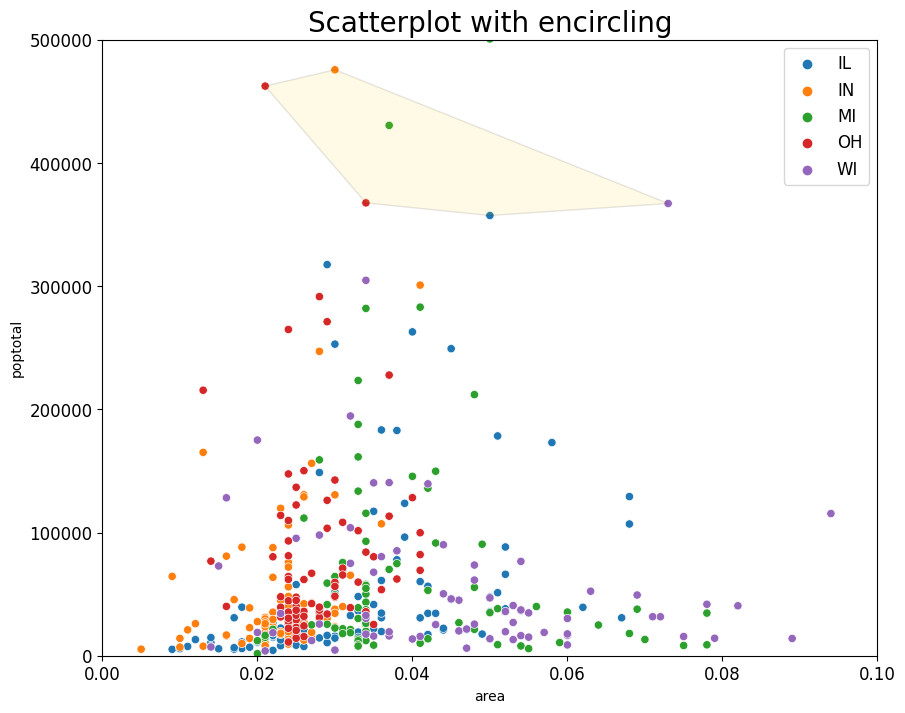

In [6]:
from matplotlib import patches
from scipy.spatial import ConvexHull

fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x='area', y='poptotal', data=midwest, hue='state')

plt.xlim(0, 0.1)
plt.ylim(0, 5e5)

# Custom function that draws a polygon given some points as vertices
# src: https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot
# see references below
def encircle(x, y, ax=None, **kw):
    if not ax:
        ax = plt.gca()
    p = np.c_[x, y] # similar to R's cbind()
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices, :], **kw)
    ax.add_patch(poly)

# Select data to be encircled
midwest_encircle_data = midwest.query('poptotal > 350000 & poptotal < 5e5 & area > 0.01 & area < 0.1')
# equivalent:
# cond = (midwest.poptotal > 350000) & (midwest.poptotal < 5e5) & (midwest.area > 0.01) & (midwest.area < 0.1)
# midwest_encircle_data = midwest.loc[cond, :]

# Draw polygon surrounding vertices    
encircle(midwest_encircle_data.area, midwest_encircle_data.poptotal, ec="k", fc="gold", alpha=0.1)

# Decorations
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Scatterplot with encircling", fontsize=20)
plt.legend(fontsize=12)    
plt.show()   

For more information:
* [numpy.c_](https://numpy.org/doc/stable/reference/generated/numpy.c_.html)
* [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)

# Counts chart / Jittered scatterplot

A counts chart avoids the problem of overlapping points by increasing the size of the dots depending on how many points lie in that spot. So, the larger the size of the dot the more is the concentration of data points around that.

In [102]:
# create a working copy of the original data
df = mpg.copy()
df_counts = df.groupby(['hwy', 'cty']).size().reset_index(name='counts')
df_counts.head()

,hwy,cty,counts
0,12,9,5
1,14,11,2
2,15,11,10
3,16,11,3
4,16,12,2


In [ ]:
plt.figure(figsize=(8, 6))    
sns.stripplot(x="cty", y="hwy", data=df_counts, sizes=df_counts.counts.values*5)

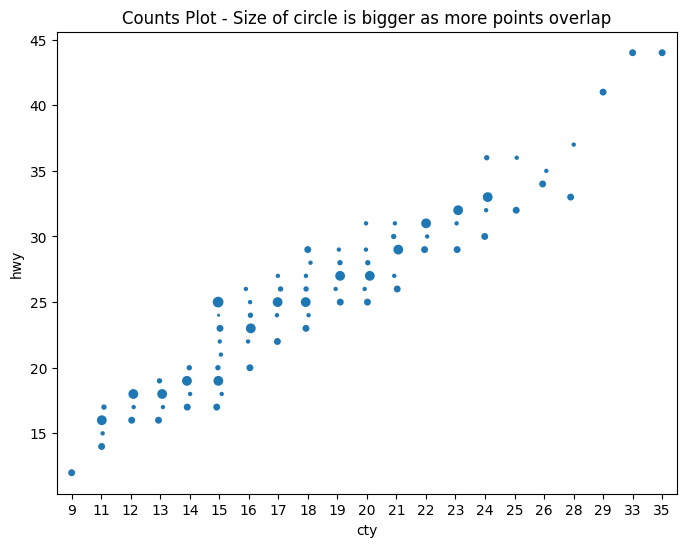

In [8]:
plt.figure(figsize=(8, 6))    
sns.stripplot(x="cty", y="hwy", data=df_counts, sizes=df_counts.counts.values*5)

plt.title('Counts Plot - Size of circle is bigger as more points overlap')
plt.show()

Another solution is to add jittering:

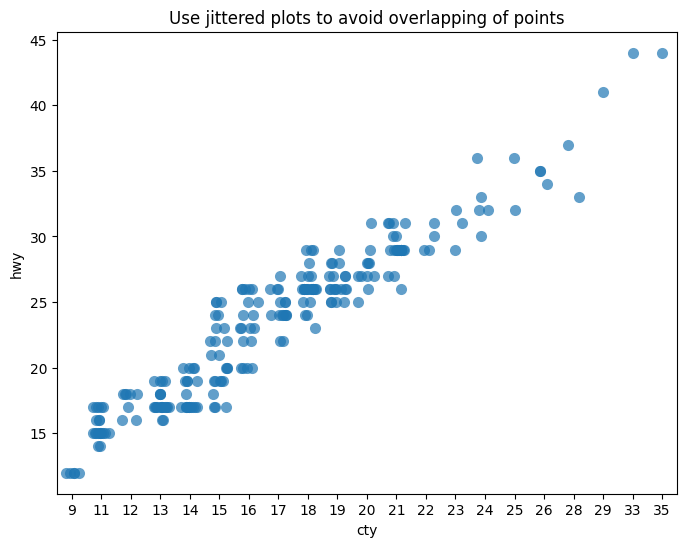

In [9]:
plt.figure(figsize=(8, 6))    
sns.stripplot(x="cty", y="hwy", data=df, jitter=0.3, alpha=0.7, size=8)

plt.title('Use jittered plots to avoid overlapping of points')
plt.show()

# Correlogram / heatmap

In a heatmap, the values of a matrix are represented as colors. The typical use case for a heatmap is to visualize a correlation matrix, thus creating a correlogram.

[Example](https://drive.google.com/uc?export=view&id=16sjHDkKiLpKVHpQFfna9fS9-qVJZp9Xa)

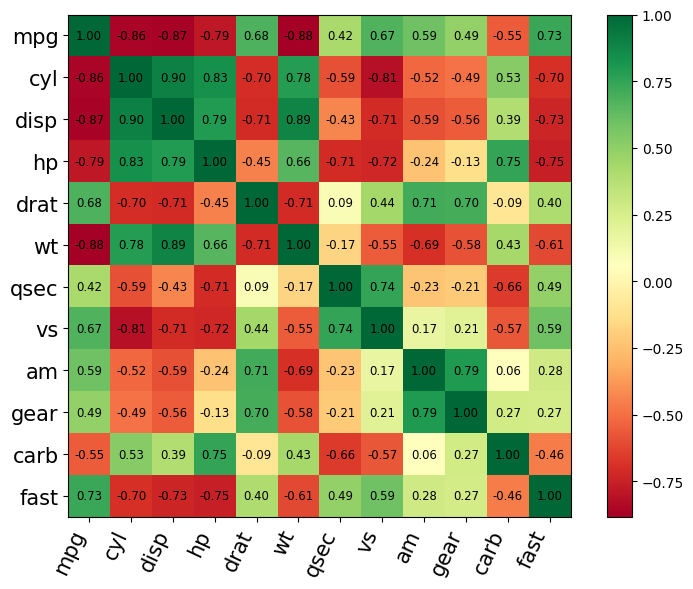

In [10]:
corr = cars.corr(method='pearson', numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 6))

# step 0: create heatmap
im = ax.imshow(corr, cmap='RdYlGn')
fig.colorbar(im, orientation='vertical', fraction=0.05)

# # step 1: set labels
ax.set_xticks(np.arange(len(corr)), labels=corr.columns)
ax.set_yticks(np.arange(len(corr)), labels=corr.columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right', fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# step 2: add text annotations
from itertools import product
seq = range(len(corr))
for i, j in product(seq, seq): # itertools' product avoids writing a nested for loop
    text = ax.text(i, j, f"{corr.iloc[i, j]:.2f}",
                   ha="center", va="center",
                   size="small")

plt.tight_layout()
plt.show()

With seaborn, it is much easier to create a heatmap with annotations:

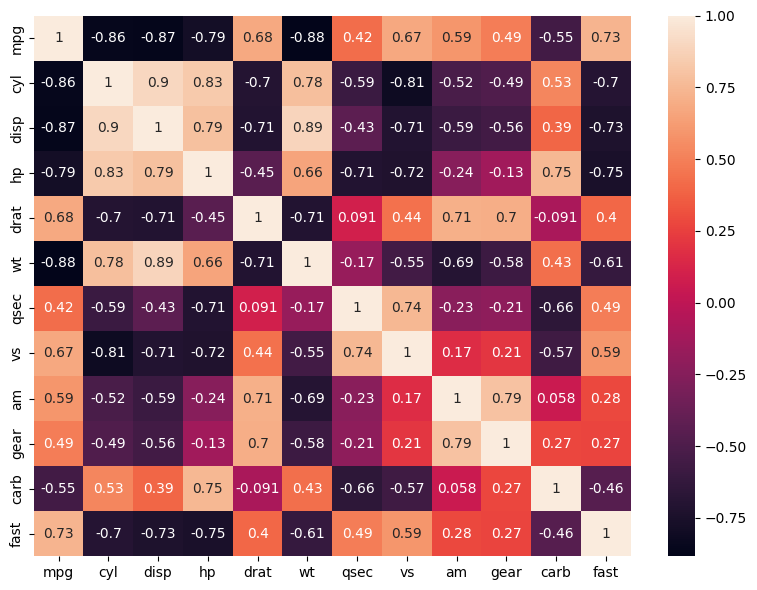

In [11]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

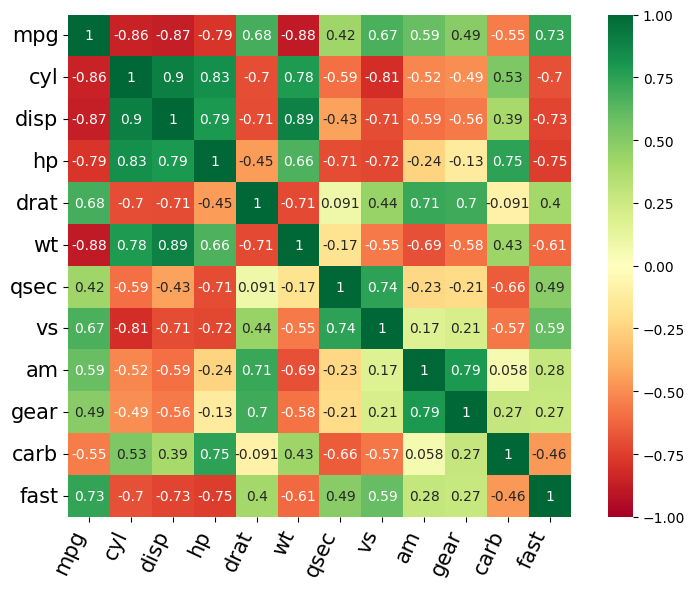

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, annot=True, ax=ax,
            vmin=-1,
            vmax=1,
            cmap='RdYlGn', # sns.diverging_palette(20, 220, n=200), # 'RdYlGn'
            square=True)


# optional:
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right', fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=15)

plt.tight_layout()
plt.show()

If you are interested in plotting a diagonal correlogram, you can leverage the argument `mask` of `sns.heatmap()`, which accepts a boolean array specifiyng which cells should be hidden from the visualization. For example, you may want to hide the upper triangular portion of `corr`:

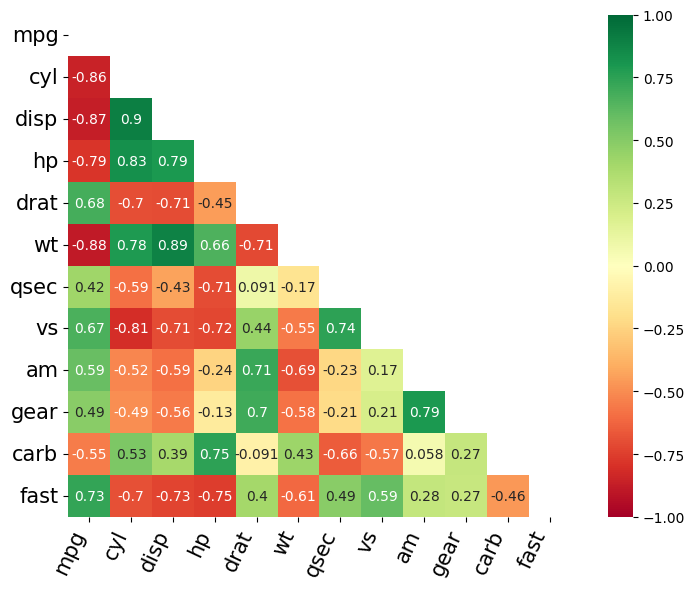

In [13]:
# create a mask for the upper triangular portion of corr
mask = np.triu(np.ones_like(corr, dtype=bool))


fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, annot=True, ax=ax,
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            mask=mask,
            square=True)


# optional:
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right', fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=15)

plt.tight_layout()
plt.show()

# Diverging bars

If you want to see how the items are varying based on a single metric and visualize the order and amount of this variance, the diverging bars is a great tool. It helps to quickly differentiate the performance of groups in your data and is quite intuitive and instantly conveys the point.

[Example](https://drive.google.com/uc?export=view&id=1BFHIwEDJjEH4DBXWjmRvbIkH1lk7GwAW)

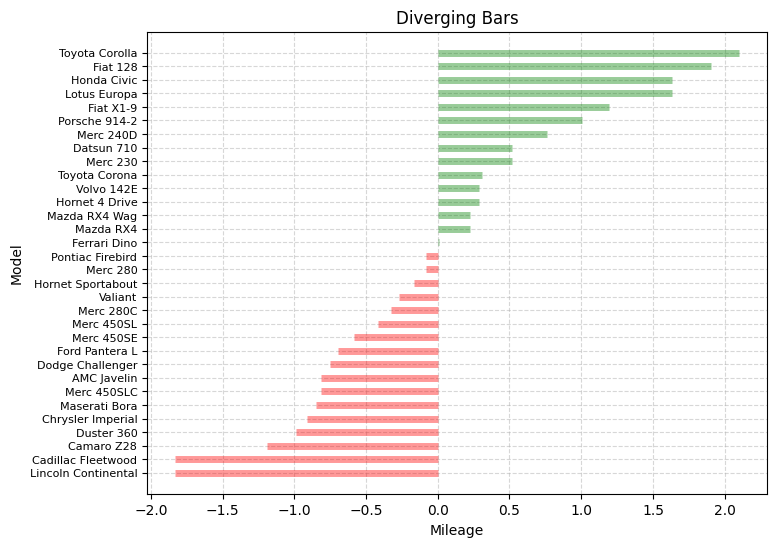

In [14]:
# data prep: compute z-values
df = cars.copy()
x = df.loc[:, ['mpg']]
df['mpg_z'] = (x - x.mean())/x.std()
df['colors'] = ['red' if x < 0 else 'green' for x in df['mpg_z']]
df.sort_values('mpg_z', inplace=True)
df.reset_index(inplace=True) # reindex dataframe to keep sorting

plt.figure(figsize=(8, 6))
# draw bars as thick horizontal lines
plt.hlines(y=df.index, xmin=0, xmax=df.mpg_z, color=df.colors, alpha=0.4, linewidth=5)

# decorate
plt.yticks(df.index, df.cars, fontsize=8)
plt.grid(linestyle='--', alpha=0.5)
plt.gca().set(xlabel='Mileage',
              ylabel='Model',
              title='Diverging Bars')
plt.show()

---

**Diverging texts** is similar to diverging bars and it preferred if you want to show the value of each items within the chart.

[Example](https://drive.google.com/uc?export=view&id=1iKYdwcT5qdqQcupwHIVMhT5xLxQmtfRB)

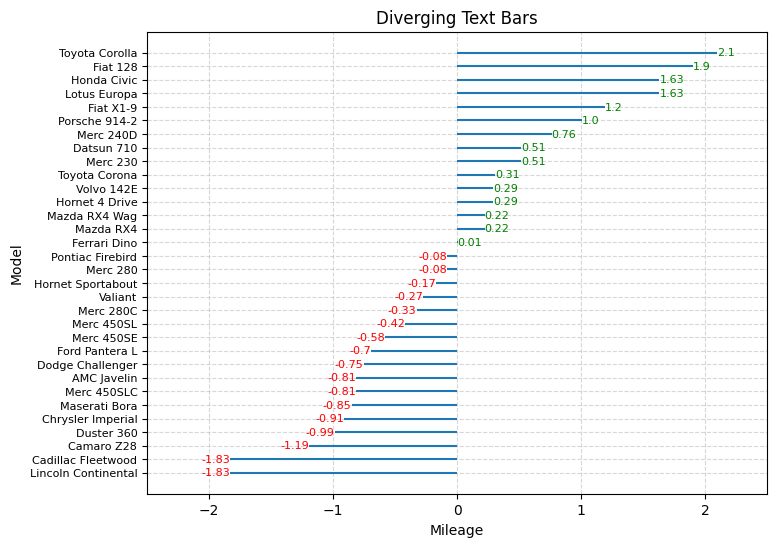

In [15]:
plt.figure(figsize=(8, 6))
# bars
plt.hlines(y=df.index, xmin=0, xmax=df.mpg_z)
# text annotations
for x, y, value in zip(df.mpg_z, df.index, df.mpg_z):
    t = plt.text(x, y, round(value, 2),
                 va='center',
                 ha='right' if x < 0 else 'left', 
                 color='red' if x < 0 else 'green',
                 size=8,
                )

plt.yticks(df.index, df.cars, fontsize=8)
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-2.5, 2.5) # add extra space to both ends
plt.gca().set(xlabel='Mileage',
              ylabel='Model',
              title='Diverging Text Bars')
plt.show()

---

**Diverging dot plot**: compared to diverging bars, the absence of bars reduces the amount of contrast and disparity between the groups.
In this example, we also highlight two regions of the plot using shaded areas, which are drawn using matplotlib's `patches.Rectangle()`.

[Example](https://drive.google.com/uc?export=view&id=1b4HwhQYmjTzhVRDswjPzJvUA6oF17ZMX)

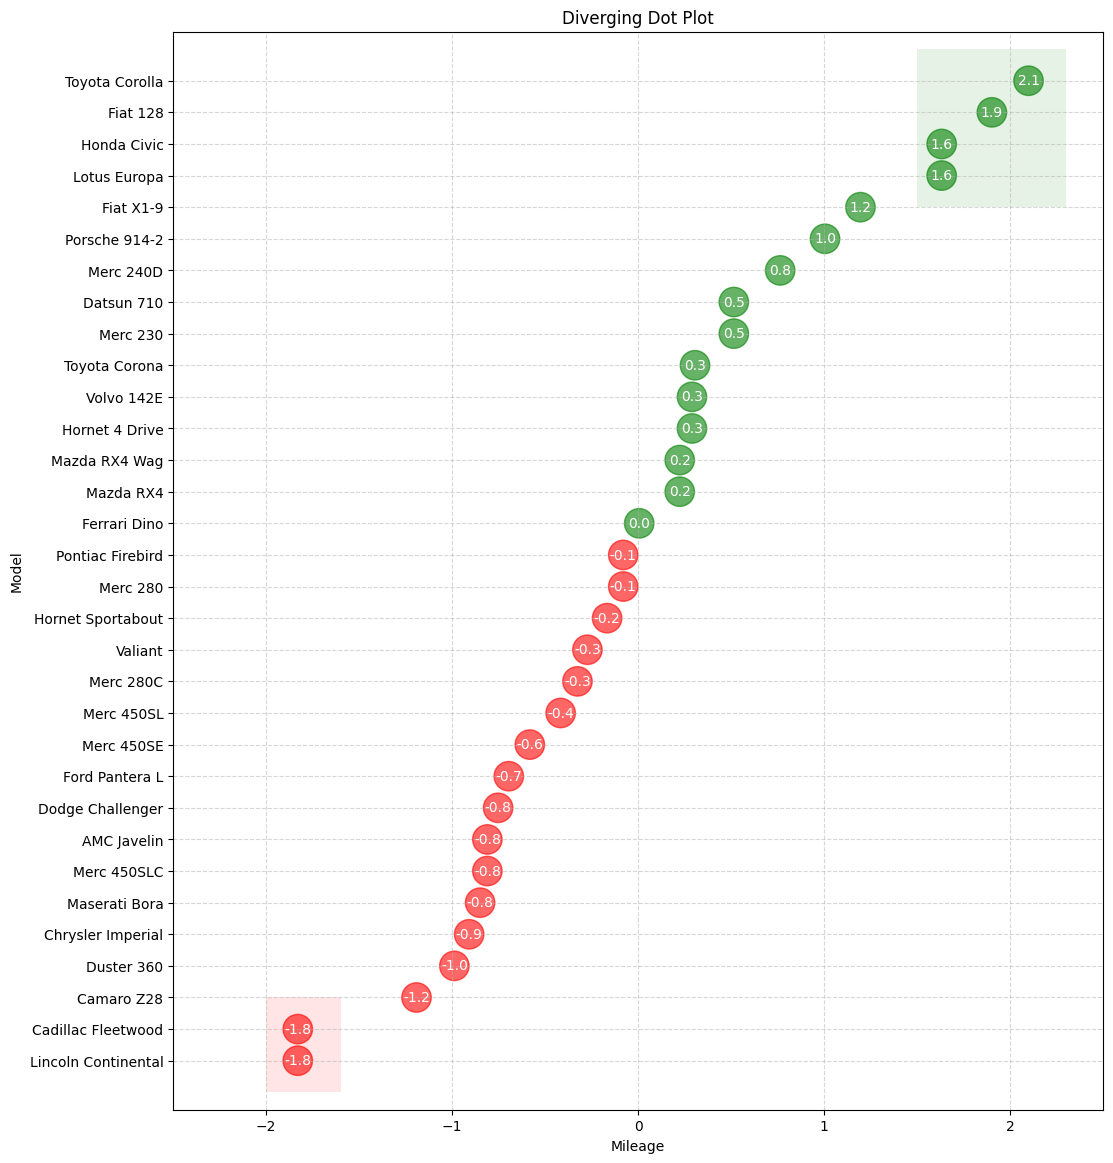

In [16]:
plt.figure(figsize=(12, 14))
# large points
plt.scatter(df.mpg_z, df.index, s=450, alpha=.6, color=df.colors)
# text annotations
for x, y, tex in zip(df.mpg_z, df.index, df.mpg_z):
    t = plt.text(x, y, round(tex, 1), ha='center', 
                 va='center',
                 color= 'white',
                )

# decorations
plt.yticks(df.index, df.cars)
plt.grid(linestyle='--', alpha=0.5)
plt.gca().set(xlabel='Mileage',
              ylabel='Model',
              title='Diverging Dot Plot')
plt.xlim(-2.5, 2.5)

# shaded areas
p1 = patches.Rectangle((1.5, 27), width=0.8, height=5, alpha=.1, facecolor='green') # 27 is the index of "Fiat X1-9"
p2 = patches.Rectangle((-2.0, -1), width=0.4, height=3, alpha=.1, facecolor='red')
plt.gca().add_patch(p1)
plt.gca().add_patch(p2)

plt.show()

# Cleveland dot plot

A dot plot conveys the rank order of the items: since it is aligned along the horizontal axis, you can better visualize how far the points are from each other.

[Example](https://drive.google.com/uc?export=view&id=1NlOIZLlFFkko4zw02GYY4ff4ya61NFg9)

In [103]:
# Prepare Data
df_raw = mpg.copy()
# compute mean 'hwy' by manufacturer
df = df_raw[['hwy', 'manufacturer']].groupby('manufacturer').mean()
df.sort_values('hwy', inplace=True)
df.reset_index(inplace=True)
df.head()

,manufacturer,hwy
0,land rover,16.500000
1,lincoln,17.000000
2,jeep,17.625000
3,dodge,17.945946
4,mercury,18.000000


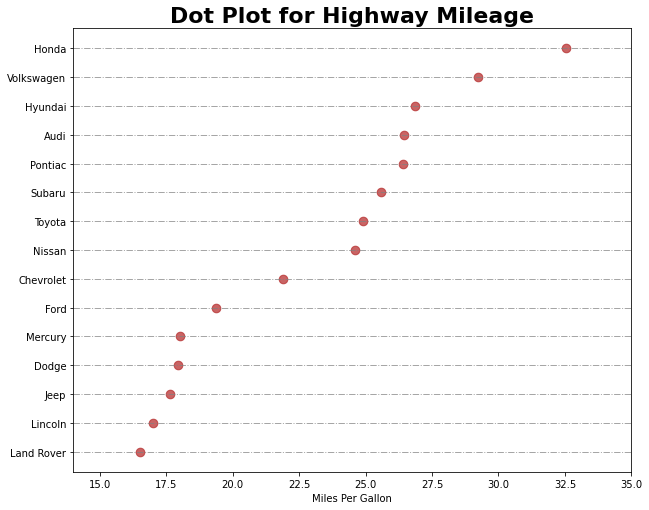

In [104]:
# define reasonable limits for x axis
x_min = df.hwy.min().round() - 2
x_max = df.hwy.max().round() + 2

# Draw plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=72)
# horizontal dashed lines
ax.hlines(y=df.index, xmin=x_min, xmax=x_max, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
# data points
ax.scatter(y=df.index, x=df.hwy, s=75, color='firebrick', alpha=0.7)

# decorations
font = {'size': 22, 'family': 'sans-serif', 'weight': 'bold'} # use a font dict if you want to change multiple font properties at once
ax.set_title('Dot Plot for Highway Mileage', fontdict=font)
ax.set_xlabel('Miles Per Gallon')
ax.set_yticks(df.index)
ax.set_yticklabels(df.manufacturer.str.title(), ha='right')
ax.set_xlim(x_min, x_max)
plt.show()

# Dumbbell plot

Dumbbell plots convey the ‘before’ and ‘after’ positions of various items along with the rank ordering of the items. They are very useful to visualize the effect of a particular project / initiative on different objects.

[Example](https://drive.google.com/uc?export=view&id=1Rgfz4is8E2yc_0xG2rNrKr9LJAGpaOIr)

In [105]:
df = health.copy()
df.sort_values('pct_2014', inplace=True)
df.reset_index(inplace=True)
df.head()

,index,Area,pct_2014,pct_2013
0,25,Boston,0.04,0.04
1,23,Pittsburgh,0.06,0.07
2,22,Baltimore,0.06,0.09
3,24,Minneapolis,0.06,0.08
4,21,San Francisco,0.08,0.11


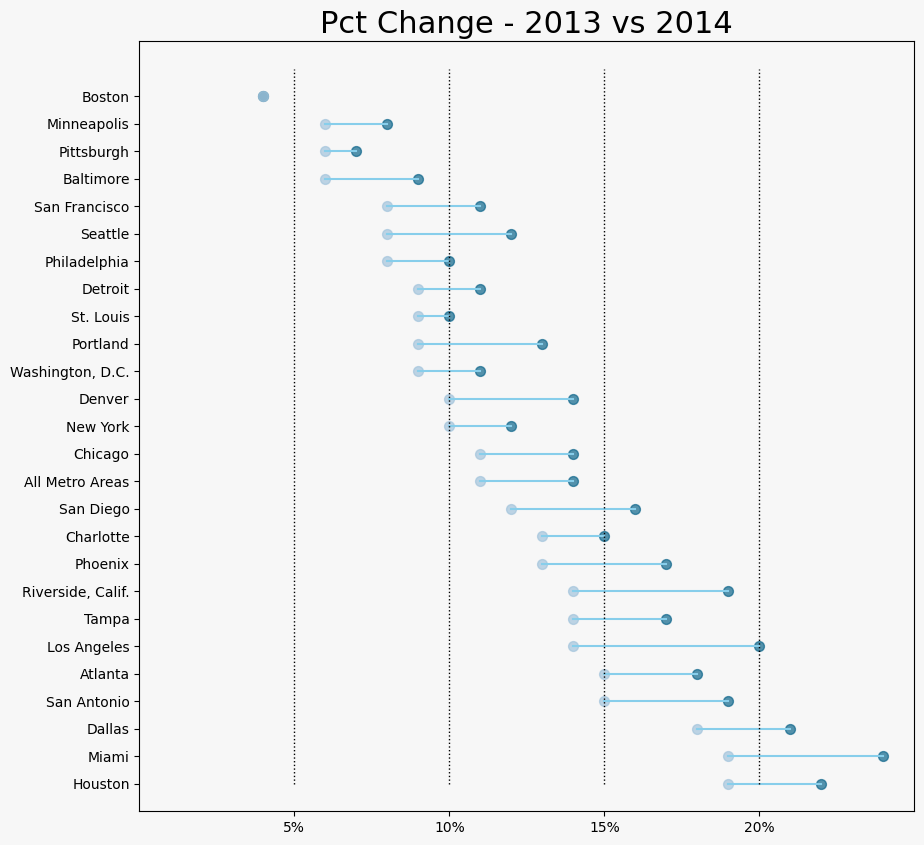

In [106]:
# Function to draw line segment
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mpl.lines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='#f7f7f7') # facecolor = figure background color

# points
ax.scatter(x=df['pct_2013'], y=df['index'], s=50, color='#0e668b', alpha=0.7) # darker blue
ax.scatter(x=df['pct_2014'], y=df['index'], s=50, color='#a3c4dc', alpha=0.7) # lighter blue

# line Segments
for i, p1, p2 in zip(df['index'], df['pct_2013'], df['pct_2014']):
    
    newline([p1, i], [p2, i], 'skyblue')

# vertical lines
styles = dict(color='black', alpha=1, linewidth=1, linestyles='dotted')
for xx in np.linspace(0.05, 0.20, num=4, endpoint=True):
    ax.vlines(x=xx, ymin=0, ymax=26, **styles)

# decorations
ax.set_facecolor('#f7f7f7') # facecolor = axes background color
ax.set_title("Pct Change - 2013 vs 2014", fontsize=22)
ax.set(xlim=(0, .25), ylim=(-1, 27), ylabel='')
ax.set_xticks([.05, .1, .15, .20])
ax.set_xticklabels(['5%', '10%', '15%', '20%'])
ax.set_yticks(df['index'])
ax.set_yticklabels(df.Area)
plt.show()

# Ridgeline plot

Ridgeline plots (Joy plots) allow the density curves of different groups to overlap: they are a great way to visualize the distribution of a large number of groups in relation to each other. It looks pleasing to the eye and conveys just the right information clearly. It can be easily built using the `joypy` package which is based on matplotlib and pandas.

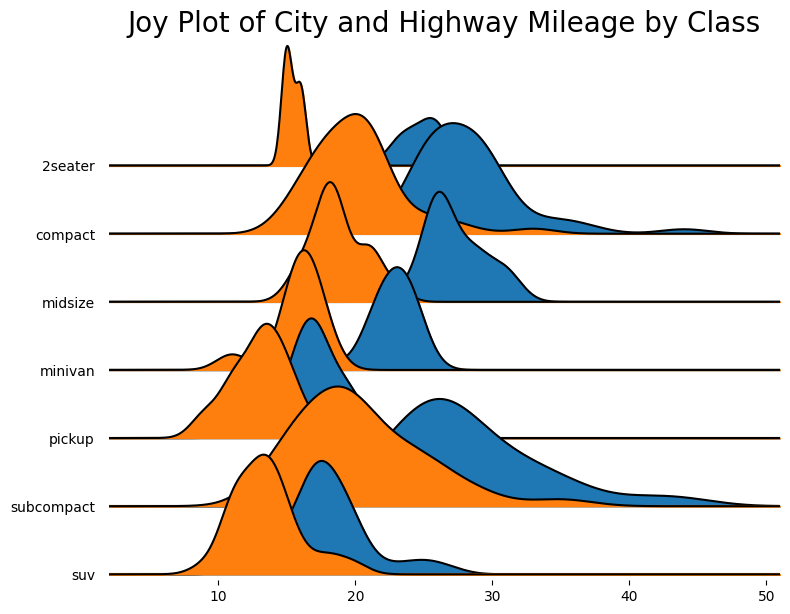

In [109]:
import joypy # pip install joypy

# Draw Plot
fig, axes = joypy.joyplot(mpg, column=['hwy', 'cty'], by="class", 
                          ylim='own', 
                          figsize=(8, 6))

# Decoration
plt.title('Joy Plot of City and Highway Mileage by Class', fontsize=20)
plt.show()

According to `pyjoy`'s Author...

> The R package ggridges (...) is much better developed/maintained than this one -- and I strongly suggest you use that if you can use R and ggplot.

# Waffle chart

Waffle charts show the compositions of groups in a larger population. Here we directly use the `pywaffle` package.

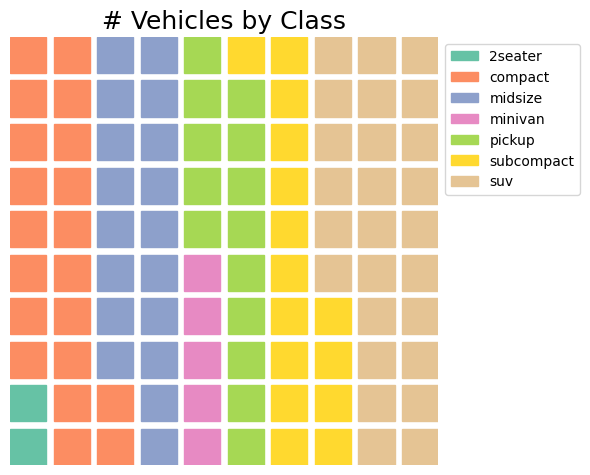

In [111]:
from pywaffle import Waffle

# data
df_raw = mpg.copy()

# compute the number of elements belonging to each "class"
df = df_raw.groupby("class").size().reset_index(name="counts")
# get the class labels
labels = df['class'].tolist()

fig = plt.figure(FigureClass=Waffle,
                 rows=10,
                 columns=10,
                 values=df.counts,
                 labels=labels,
                 legend={'bbox_to_anchor': (1, 1)},
                 title={"label": "# Vehicles by Class", 
                        "loc": "center", 
                        "fontsize": 18},
                 figsize=(6, 6),
                )

`pywaffle` allows you to add multiple waffle charts as subplots to the same figure. In this case, you need to merge the parameters for each plot as dict values and pass them to the argument `plots`. The keys of this dict are *integers* describing the position of the subplot, in the format `312`, standing for nrow, ncol, index.

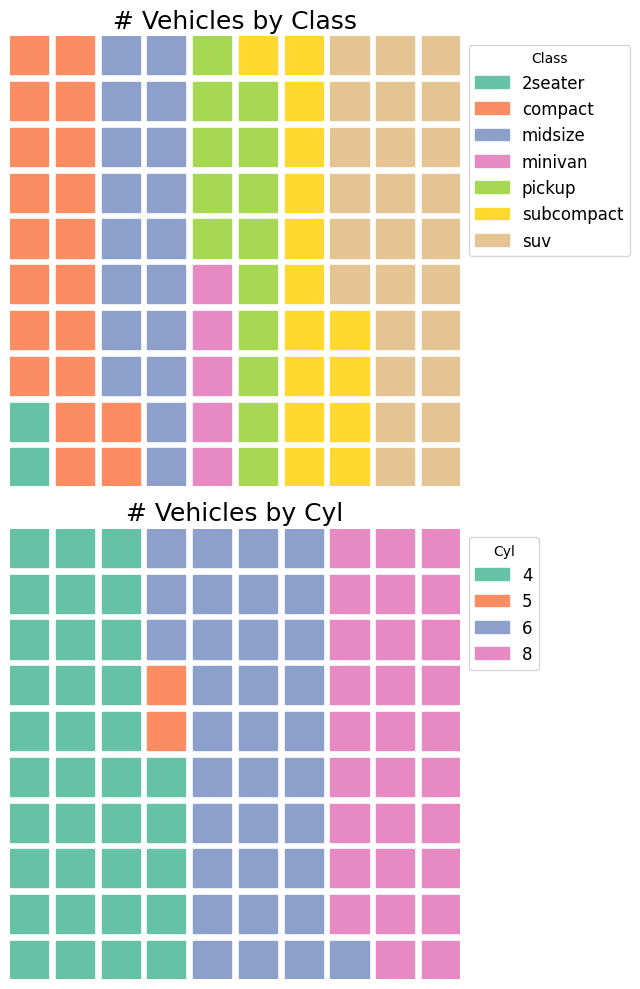

In [112]:
# Prepare distinct data frames to hold data for the different waffles
# By Class
df1 = df_raw.groupby('class').size().reset_index(name='counts')

# By Cylinders
df2 = df_raw.groupby('cyl').size().reset_index(name='counts')

# Draw Plot and Decorate
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        211: {
            'values': df1.counts,
            'labels': df1['class'].tolist(),
            'legend': {'bbox_to_anchor': (1, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': '# Vehicles by Class', 'loc': 'center', 'fontsize':18},
        },
        212: {
            'values': df2.counts,
            'labels': df2['cyl'].tolist(),
            'legend': {'bbox_to_anchor': (1, 1), 'fontsize': 12, 'title':'Cyl'},
            'title': {'label': '# Vehicles by Cyl', 'loc': 'center', 'fontsize':18},
        },
    },
    rows=10,
    columns=10,
    # cmap_name="Accent",
    figsize=(10, 10)
)

# Treemap

Treemaps are similar to pie charts: they do a better job without misleading the contributions by each group. In the below example, we use the Python module `squarify`.

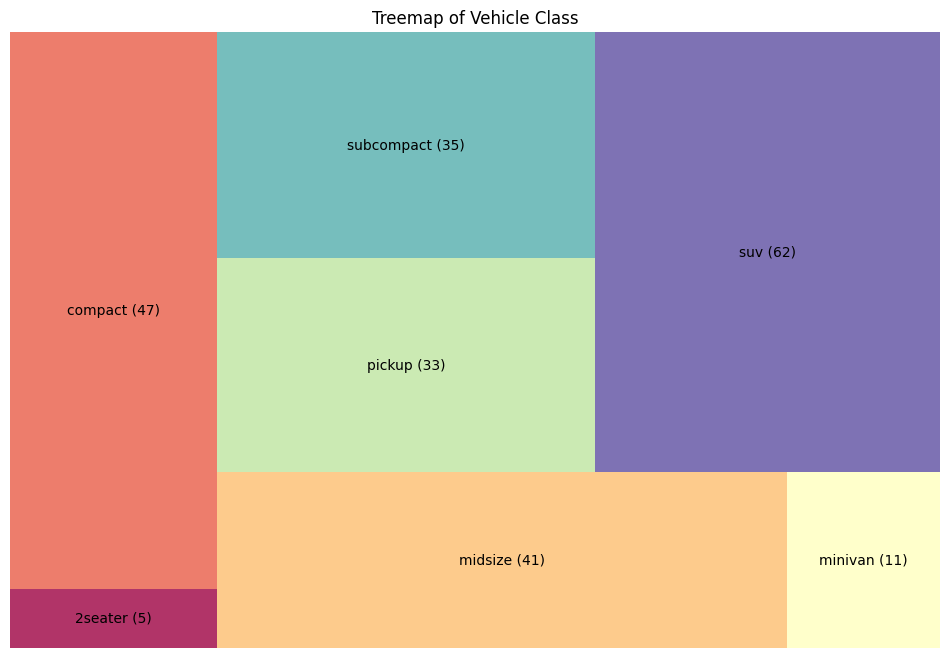

In [113]:
import squarify

# Import
df_raw = mpg.copy()

# compute the number of elements belonging to each "class"
df = df_raw.groupby("class").size().reset_index(name="counts")
n_categories = df.shape[0]
# create labels as "class name (class count)"
labels = df.apply(lambda x: f'{x[0]} ({x[1]})', axis=1)
sizes = df['counts'].tolist()
# create n_categories unique colors
colors = [plt.cm.Spectral(i/(n_categories-1)) for i in range(n_categories)]

# draw plot
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

# decorate
plt.title("Treemap of Vehicle Class")
plt.axis("off")
plt.show()

The following example shows a little more customization (larger text, padding):

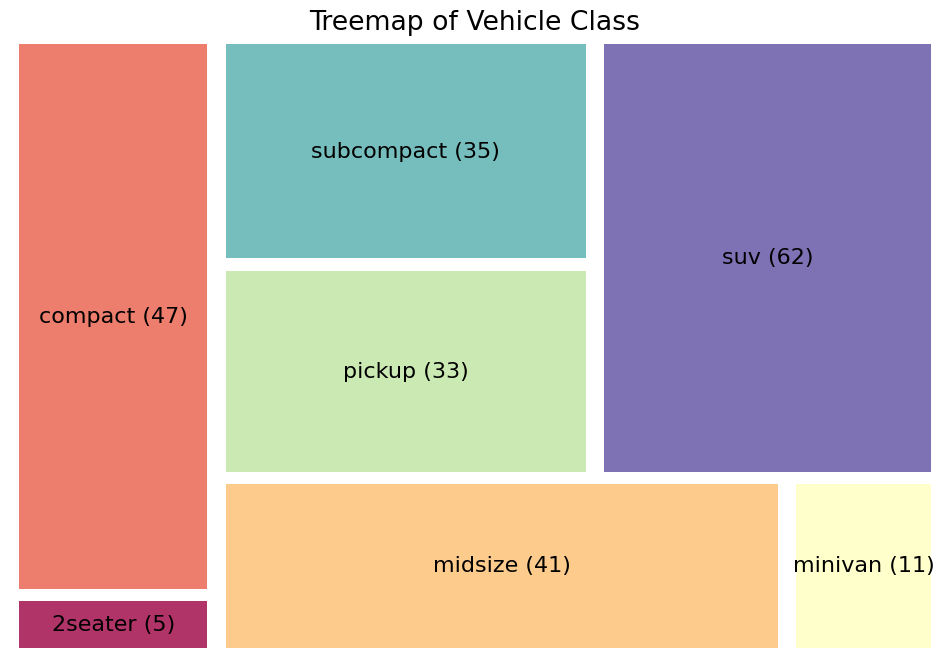

In [114]:
plt.figure(figsize=(12, 8))

with mpl.rc_context({'font.size': 16}): # temporarily change rcParams
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, pad=True)
    plt.title("Treemap of Vehicle Class")

plt.axis("off")
plt.show()


# Dendrogram
A Dendrogram groups similar points together based on a given distance metric and organizes them in tree like links based on the point’s similarity.

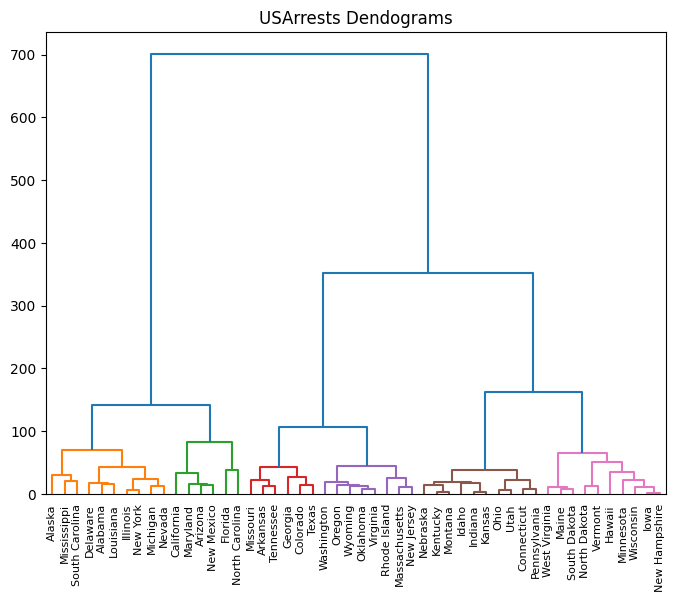

In [122]:
import scipy.cluster.hierarchy as shc

df = arrests.copy()

# hierarchical clustering (returns a linkage matrix as numpy array)
hc = shc.linkage(df[['Murder', 'Assault', 'UrbanPop', 'Rape']], method='ward')

# plot dendrogram
plt.figure(figsize=(8, 6))
dend = shc.dendrogram(hc,
                      labels=df.State.values,
                      color_threshold=100)
plt.title("USArrests Dendograms")
# plt.xticks(fontsize=10)
plt.show()

If the dendrogram is part of a more complex figure, you can pass to `shc.dendrogram` an Axes object through the `ax` argument.

# Cluster Plot

Cluster plots can be used to demarcate points that belong to the same cluster. Below is a representational example to group the US states into 5 groups based on the USArrests dataset. This cluster plot uses the `murder` and `assault` columns as X and Y axis. Alternatively, you can use the first two principal components as the X and Y axis.

/home/gia/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


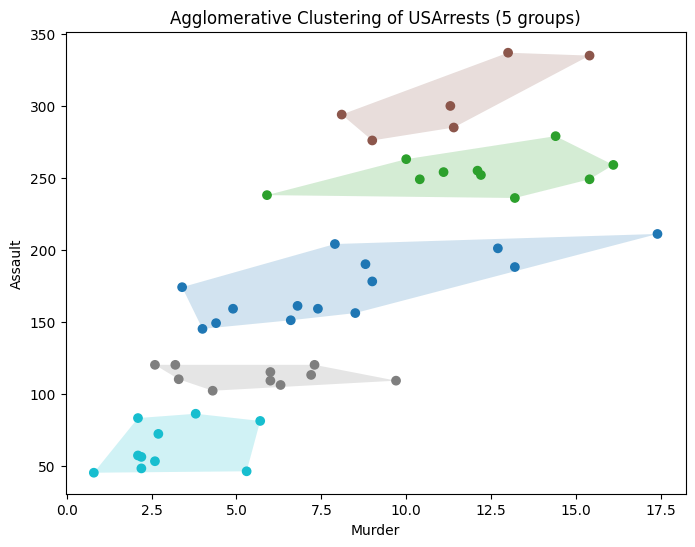

In [116]:
from sklearn.cluster import AgglomerativeClustering

df = arrests.copy()

# clustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df[['Murder', 'Assault', 'UrbanPop', 'Rape']])  

plt.figure(figsize=(8, 6))
# scatterplot colored by clustering labels
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster.labels_, cmap='tab10')  

groups = np.unique(cluster.labels_)
n_groups = len(groups)
# pick n_groups unique colors from the tab10 palette
my_colors = [plt.cm.tab10(i/(n_groups-1)) for i in range(n_groups)]

# draw polygon surrounding vertices
for group in groups:
    encircle(df.loc[cluster.labels_ == group, 'Murder'],
             df.loc[cluster.labels_ == group, 'Assault'],
             fc=my_colors[group],
             alpha=0.2,
             linewidth=0)

# Decorations
plt.xlabel('Murder')
plt.ylabel('Assault')
plt.title(f'Agglomerative Clustering of USArrests ({n_groups} groups)')
plt.show()

# Andrews plot
The Andrews plot (or Andrews curve) helps visualize if there are inherent groupings of the numerical features based on a given stratifying variable. Andrews curves are a projection of multivariate data into a 2D space: each observation is represented by a curve. If two curves are close to each other, then the corresponding observations are also close.

If the features (columns in the dataset) do not help discriminate the group (e.g., `cyl` in `mtcars` data), then the lines will not be well segregated as you see below.

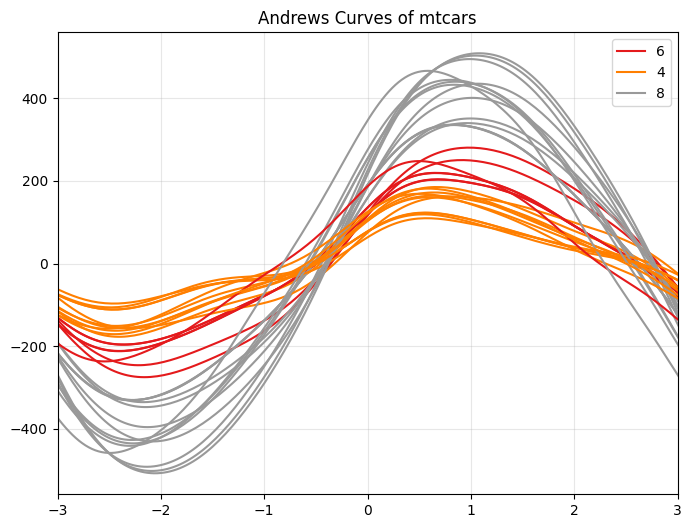

In [117]:
from pandas.plotting import andrews_curves

df = cars.copy()
df.drop(['cars', 'carname'], axis=1, inplace=True)

plt.figure(figsize=(8, 6))
andrews_curves(df, 'cyl', colormap='Set1')

# decorations
plt.title('Andrews Curves of mtcars')
plt.xlim(-3, 3)
plt.grid(alpha=0.3)
plt.show()

# Parallel Coordinates

Similarly to Andrews plots, parallel coordinates helps to visualize if a feature segregates the groups effectively.

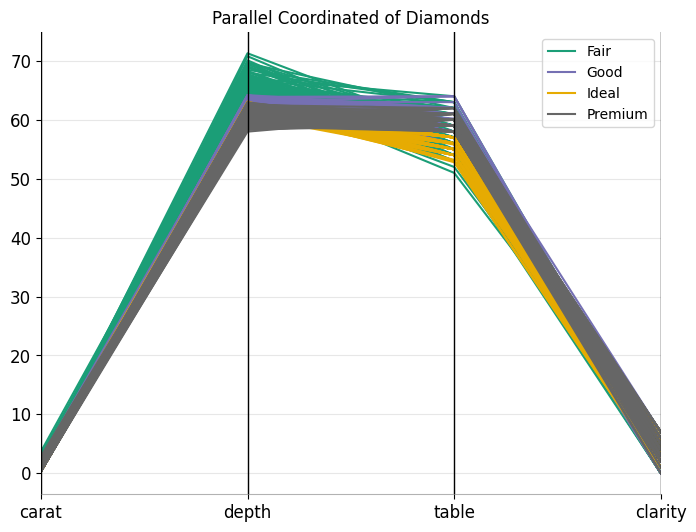

In [118]:
from pandas.plotting import parallel_coordinates

df = diamonds.copy()

plt.figure(figsize=(8, 6))
parallel_coordinates(df, 'cut', colormap='Dark2')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.title('Parallel Coordinated of Diamonds')
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Animations

Matplotlib has its own animation framework:

In [119]:
import matplotlib.animation as animation

Using `animation.FuncAnimation`, we are going to create a simple animation of sine and cosine functions progressively appearing on the main plot.

The usual call is `FuncAnimation(fig, update, interval)`, with

- a Figure object, `fig`
- a function `update` that modifies the data plotted on `fig`
- an `interval` parameter specifying the time (ms) between two frames.

The typical workflow is then:

1. Plot the main figure with all required artists (i.e., the plot objects that will be animated). Save the artists to their own variables.
2. Create an animation function that updates the data in each artist to generate the new frame at each function call.
3. Create a `FuncAnimation` object.

The final animation can either be saved with `Animation.save` or shown with `plt.show`.

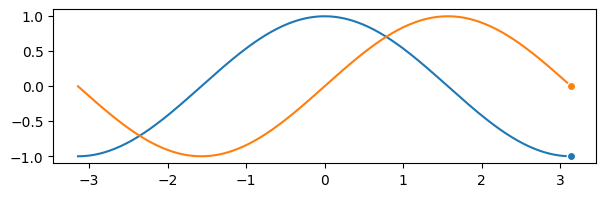

In [120]:
fig, ax = plt.subplots(figsize=(7, 2))

X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
cosine, sine = np.cos(X), np.sin(X)

(line1,) = ax.plot(X, cosine, marker='o', markevery=[-1], markeredgecolor="white") # markevery=[-1] specifies a single marker at the end
(line2,) = ax.plot(X, sine, marker='o', markevery=[-1], markeredgecolor="white")

def update(frame):
    line1.set_data(X[:frame], cosine[:frame])
    line2.set_data(X[:frame], sine[:frame])

anim = animation.FuncAnimation(fig, update, interval=30, frames=40)
plt.show()

Only the final snapshot of the animation is shown as a static plot.

To save the animation, we can have matplotlib write a movie file (not too many options, though) or, better, we can use `ffmpeg` to create the movie (it has to be installed separately).

In [121]:
writer = animation.FFMpegWriter(fps=30)
anim = animation.FuncAnimation(fig, update, interval=10, frames=len(X))
anim.save("sine-cosine.mp4", writer=writer, dpi=100)

/home/gia/.local/lib/python3.10/site-packages/matplotlib/animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'